## WHO API

In [1]:
import requests;

url     = "https://covid-19-coronavirus-statistics.p.rapidapi.com/v1/stats";
query   = {"country":"Mexico"};
headers = {
    'x-rapidapi-host': "covid-19-coronavirus-statistics.p.rapidapi.com",
    'x-rapidapi-key': "7e6cf1dbafmsha291e24ccb65407p1469b1jsn307b9be6aeef"
};

response = requests.request("GET", url, headers=headers, params=query);
print(response.text);

{"error":false,"statusCode":200,"message":"OK","data":{"lastChecked":"2020-04-28T17:22:11.616Z","covid19Stats":[{"city":null,"province":null,"country":"Mexico","lastUpdate":"2020-04-28T02:30:32+00:00","keyId":"Mexico","confirmed":15529,"deaths":1434,"recovered":9086}]}}


---
##### https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6
---

## 'Our World in Data' data compilation
#### Sourced from the World Health Organization (WHO) Situation Reports
##### https://ourworldindata.org/coronavirus
##### https://ourworldindata.org/coronavirus-source-data; https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases
##### https://www.who.int/emergencies/diseases/novel-coronavirus-2019/situation-reports/

##### Setting up tqdm
```python
pip install ipywidgets 
jupyter nbextension enable --py widgetsnbextension
jupyter labextension install @jupyter-widgets/jupyterlab-manager
```

In [2]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()
# Activate tqdm in a notebook [https://towardsdatascience.com/progress-bars-in-python-4b44e8a4c482]

In [3]:
# PYTHON LIBRARIES
%matplotlib inline

import pandas as pd
import numpy as np
import dateparser
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from adjustText import adjust_text
from sklearn.preprocessing import LabelEncoder
number = LabelEncoder()
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
from datetime import datetime
from datetime import timedelta
from scipy import signal

# CONSTANTS
markerSymbol = [
    "o", #circle
    "v", #triangle_down
    "^", #triangle_up
    "<", #triangle_left
    ">", #triangle_right
    "s", #square
    "p", #pentagon
    "P", #plus (filled)
    "*", #star
    "H", #hexagon2
    "X", #x (filled)
    "D", #diamond
    "d", #thin_diamond
    "1", #tri_down
    "2", #tri_up
    "3", #tri_left
    "4", #tri_right
    "+", #plus
    "x"  #x
];

markerColour = [
    '#9e9e9e', #grey
    '#e91e63', #pink
    '#9c27b0', #purple
    '#673ab7', #deep-purple
    '#3f51b5', #indigo
    '#2196f3', #blue
    '#03a9f4', #light-blue
    '#00bcd4', #cyan
    '#009688', #teal
    '#4caf50', #green
    '#8bc34a', #light-green
    '#cddc39', #lime
    '#ffeb3b', #yellow
    '#ffc107', #amber
    '#ff9800', #orange
    '#ff5722', #deep-orange
    '#795548', #brown
    '#f44336'  #red
];

# df.loc[<ROWS RANGE> , <COLUMNS RANGE>] to get elements by index

# https://vac-lshtm.shinyapps.io/ncov_tracker/
url_confirmed = "https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv";
df_confirmed_raw = pd.read_csv(url_confirmed, delimiter=",");
display("CONFIRMED", df_confirmed_raw.head())

url_deaths = "https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_deaths_global.csv&filename=time_series_covid19_deaths_global.csv";
df_deaths_raw = pd.read_csv(url_deaths, delimiter=",");
display("DEATHS", df_deaths_raw.head())

url_recovered = "https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_recovered_global.csv&filename=time_series_covid19_recovered_global.csv";
df_recovered_raw = pd.read_csv(url_recovered, delimiter=",");
display("RECOVERED", df_recovered_raw.head())

'CONFIRMED'

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,933,996,1026,1092,1176,1279,1351,1463,1531,1703
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,548,562,584,609,634,663,678,712,726,736
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,2534,2629,2718,2811,2910,3007,3127,3256,3382,3517
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,704,713,717,717,723,723,731,738,738,743
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,24,24,24,24,25,25,25,25,26,27


'DEATHS'

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,30,33,36,36,40,42,43,47,50,57
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,26,26,26,26,27,27,27,27,28,28
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,367,375,384,392,402,407,415,419,425,432
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,35,36,37,37,37,37,40,40,40,40
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


'RECOVERED'

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,112,131,135,150,166,179,188,188,207,220
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,302,314,327,345,356,385,394,403,410,422
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,894,1047,1099,1152,1204,1355,1408,1479,1508,1558
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,205,235,248,282,309,333,344,344,344,385
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,6


In [4]:
def joinstr(x):
    if x != '': return ' - ';
    else:       return '';

def formatdate(x):
    res = x.split('/')
    res[0] = "%02d" % (int(res[0]),); # month
    res[1] = "%02d" % (int(res[1]),); # day
    res[2] = res[2]; # year
    return('-'.join(res));

def explodeDF(df_raw):
    # Remove NANs
    df_raw = df_raw.replace(np.nan, '');

    # Concatenate "Country/Region" & "Province/State" tp make the location column
    df_raw['Location'] = df_raw[["Country/Region", "Province/State"]].apply(
        # Add a " - " if the "Province/State" exists 
        lambda x: joinstr(x["Province/State"]).join(x), axis=1
    );

    # Remove unnecessary columns
    df_raw = df_raw.drop(columns=['Lat', 'Long', 'Province/State', 'Country/Region']);

    # Make the "Location" column to be the first column
    location = df_raw['Location'];
    df_raw.drop(labels=['Location'], axis=1,inplace = True);
    df_raw.insert(0, 'Location', location);
    
#     # let's take a look to the data
#     display("PROCESSED DATA", df_raw.head());

    # Build the plotable df
    date     = list(df_raw.columns);
    location = list(df_raw['Location']);
    df       = pd.DataFrame(columns=["Location", "date", "counts"]);
    
    # Explode the data frame
#     for i in range(len(location)):
    for i in tqdm(range(len(location))):
        for j in range(len(date)):
            if j > 0:
                df = df.append({
                    "Location": location[i],
                    "date":     date[j],
                    "counts":   df_raw[date[j]][i]
                }, ignore_index=True);
                
    # Sum all Provinces/States of one country
    # Get countries that are divided into several Provinces/States
    allcountries = location
    dividedCountries = [];
    for location in allcountries:
        if " - " in location:
            country = location.split(" - ")[0]
            if not(country in dividedCountries) and not(country in allcountries):
                dividedCountries.append(country)

#     # Let's take a look
#     display(dividedCountries)
    
    for country in dividedCountries:
        # Get rows that contain a specific country
        row = df_raw[df_raw['Location'].str.contains(country)]

        # Get totals for each date (column)
        row = pd.DataFrame(row.sum())

        # Add a column containing the dates
        row['date'] = date
        
        # Remove the first row, generated by .sum()
        row = row.drop('Location')
        
        # Add a column containing the country name
        row['Location'] = [country] * len(row)
        
        # Remane the '0' column as it contains the totals, calculated by .sum()
        row = row.rename(columns={0: "counts"})
        
        # Reorder the columns to match the previous data
        row = row[['Location','date','counts']]
        
        # Append the calculated totals to the existing data
        df = df.append(row);
        
        # Give each row a unique index/ID. df.index = range(len(df.index))
        df.index = df[["Location", "date"]].apply(
            # Add a " - " if the "Province/State" exists
            lambda x: joinstr(x["Location"]).join(x), axis=1
        );

#         # Let's take a look
#         display(row.head())

#     # let's take a look to the data
#     display("PROCESSED DATA", df.head());
#     df.to_csv(r'./_data_.csv', index = False);

    return df;

---
### Make data.csv ...

In [5]:
# Explode the original data
print("Exploding confirmed cases ...");
df_confirmed_explode = explodeDF(df_confirmed_raw);
print("Exploding deaths ...");
df_deaths_explode    = explodeDF(df_deaths_raw);
print("Exploding recovered cases ...");
df_recovered_explode = explodeDF(df_recovered_raw);

# # let's take a look to the data
# df_confirmed_explode.to_csv(r'./df_confirmed_explode.csv', index = False);
# df_deaths_explode.to_csv(r'./df_deaths_explode.csv', index = False);
# df_recovered_explode.to_csv(r'./df_recovered_explode.csv', index = False);
# display("PROCESSED DATA", df_confirmed_explode.head());
# display("PROCESSED DATA", df_deaths_explode.head());
# display("PROCESSED DATA", df_recovered_explode.head());

# Build the plotable dataframe with columns from several datasets
print("Building the dataset ...");
df_raw = pd.DataFrame();
df_raw = pd.concat([df_raw, df_confirmed_explode['Location']], axis=1, sort=False)
df_raw = pd.concat([df_raw, df_confirmed_explode['date']], axis=1, sort=False)
df_raw = pd.concat([df_raw, df_confirmed_explode['counts']], axis=1, sort=False)
df_raw = df_raw.rename(columns={"counts": "confirmed"})
df_raw = pd.concat([df_raw, df_deaths_explode['counts']], axis=1, sort=False)
df_raw = df_raw.rename(columns={"counts": "deaths"})
df_raw = pd.concat([df_raw, df_recovered_explode['counts']], axis=1, sort=False)
df_raw = df_raw.rename(columns={"counts": "recovered"})

# Build the plotable dataframe with CALCULATED columns
# Calculate active cases
print("Calculating active cases ...")
df_raw['active'] = df_raw['confirmed'] - df_raw['deaths'] - df_raw['recovered'];

# Calculate new cases, deaths and recoveries per day
print("Calculating new cases, deaths, recoveries and rate of growth per day ...")
df_raw['new_confirmed']   = np.NaN;
df_raw['new_deaths']      = np.NaN;
df_raw['new_recovered']   = np.NaN;
df_raw['new_active']      = np.NaN;
df_raw['rate_of_growth']  = np.NaN;
df_raw['index_confirmed'] = np.NaN;
df_raw['index_deaths']    = np.NaN;
df_raw['index_recovered'] = np.NaN;
df_raw['index_active']    = np.NaN;
currentLocation = '';
for i in tqdm(range(len(df_raw))):
    if currentLocation != df_raw['Location'][i]:
#         print(df_raw['Location'][i]);
        currentLocation = df_raw['Location'][i];
        count_confirmed = 0;
        count_deaths    = 0;
        count_recovered = 0;
        count_active    = 0;
        is_active       = False;
    else:
        df_raw['new_confirmed'][i]  = df_raw['confirmed'][i] - df_raw['confirmed'][i - 1];
        df_raw['new_deaths'][i]     = df_raw['deaths'][i]    - df_raw['deaths'][i - 1];
        df_raw['new_recovered'][i]  = df_raw['recovered'][i] - df_raw['recovered'][i - 1];
        df_raw['new_active'][i]     = df_raw['active'][i]    - df_raw['active'][i - 1];
        try:
            df_raw['rate_of_growth'][i] = float(df_raw['active'][i] / df_raw['active'][i - 1]);
        except ZeroDivisionError:
            df_raw['rate_of_growth'][i] = 0;
        
        if (df_raw['confirmed'][i] > 1000):
            df_raw['index_confirmed'][i] = count_confirmed;
            count_confirmed = count_confirmed + 1;
            
        if (df_raw['deaths'][i] > 50):
            df_raw['index_deaths'][i] = count_deaths;
            count_deaths = count_deaths + 1;
            
        if (df_raw['recovered'][i] > 2000):
            df_raw['index_recovered'][i] = count_recovered;
            count_recovered = count_recovered + 1;
            
        if (df_raw['active'][i] > 1000): is_active = True;
        if is_active:
            df_raw['index_active'][i] = count_active;
            count_active = count_active + 1;

# Format the date column
print("Formatting the dates ...")
date = list(df_raw['date'])
date = [str(dateparser.parse(str(x))) for x in date];
df_raw['date'] = date

# Save the dataframe as CSV
print("Saving CSV ...")
df_raw.to_csv(r'./data.csv', index = False);

Exploding confirmed cases ...



Exploding deaths ...



Exploding recovered cases ...



Building the dataset ...
Calculating active cases ...
Calculating new cases, deaths, recoveries and rate of growth per day ...



Formatting the dates ...
Saving CSV ...


---
### Load data from saved CSV to spare processing time ...

In [6]:
url_confirmed = "./data.csv";
df_raw = pd.read_csv(url_confirmed, delimiter=",");

# let's take a look to the data
display("PROCESSED DATA", df_raw.head());

'PROCESSED DATA'

,Location,date,confirmed,deaths,recovered,active,new_confirmed,new_deaths,new_recovered,new_active,rate_of_growth,index_confirmed,index_deaths,index_recovered,index_active
0,Afghanistan,2020-01-22 00:00:00,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,2020-01-23 00:00:00,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,Afghanistan,2020-01-24 00:00:00,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,Afghanistan,2020-01-25 00:00:00,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
4,Afghanistan,2020-01-26 00:00:00,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


### https://vac-lshtm.shinyapps.io/ncov_tracker/
---

### Print all countries

In [7]:
print('; '.join(df_raw.iloc[:]['Location'].drop_duplicates().sort_values()))
allcountries = df_raw.iloc[:]['Location'].drop_duplicates().sort_values()

Afghanistan; Albania; Algeria; Andorra; Angola; Antigua and Barbuda; Argentina; Armenia; Australia; Australia - Australian Capital Territory; Australia - New South Wales; Australia - Northern Territory; Australia - Queensland; Australia - South Australia; Australia - Tasmania; Australia - Victoria; Australia - Western Australia; Austria; Azerbaijan; Bahamas; Bahrain; Bangladesh; Barbados; Belarus; Belgium; Belize; Benin; Bhutan; Bolivia; Bosnia and Herzegovina; Botswana; Brazil; Brunei; Bulgaria; Burkina Faso; Burma; Burundi; Cabo Verde; Cambodia; Cameroon; Canada; Canada - Alberta; Canada - British Columbia; Canada - Diamond Princess; Canada - Grand Princess; Canada - Manitoba; Canada - New Brunswick; Canada - Newfoundland and Labrador; Canada - Northwest Territories; Canada - Nova Scotia; Canada - Ontario; Canada - Prince Edward Island; Canada - Quebec; Canada - Recovered; Canada - Saskatchewan; Canada - Yukon; Central African Republic; Chad; Chile; China; China - Anhui; China - Beij

### function to plot the number of 'new_cases', 'new_deaths', 'total_cases' or 'total_deaths' per country

In [8]:
def covid19plot(x_str, y_str, countries, legPos='best', xlogScale=False, ylogScale=False, annotations=True, adjusttxt=True):
    # Assign a numeric value to string data type values
    df_num = df_raw.copy();
    for col in range(len(df_raw.columns)):
        if str(type(df_raw.iloc[0 , col])) == "<class 'str'>":
            df_num.iloc[: , col] = number.fit_transform(df_raw.iloc[: , col].astype('str'))

    # Get the string and numeric values in one df
    df_fil = pd.DataFrame(df_raw);
    df_fil = df_fil.join(
        pd.DataFrame(
            df_num.iloc[:]['Location']
        ).rename(
            columns={"Location": "LocationID"}
        )
    );

    # PLOT SETUP
    scale = 7;
    fig   = plt.figure(figsize=(3*scale, 2*scale));
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.tight_layout();

    reffontsize = 16;

    # Stablish the plot area
    ax0 = plt.gca()

    if xlogScale: plt.xscale('log');
    if ylogScale: plt.yscale('log');

    texts_ax0 = [];
    for c in countries:
        for ystr in y_str:
            ## Remove NANs from interesting x,y data
            #df_fil = df_fil.dropna(subset=[x_str, ystr]);
            
#             # Define x axis
#             if useIndex: x_str = 'index_confirmed';
#             else:        x_str = 'date';
            
            # Define y axis
            if (ystr == 'rate_of_growth'):
                y_units = r'$[of \cdot active \cdot cases]$';
                ax0.axhline(y=1, linestyle=':', color=markerColour[0]);
            else:                          y_units = r'$[No. cases]$';

            # Extract data from a specific country
            df_county = df_fil[df_fil.Location.isin([c])]
            if ylogScale:
                df_county = df_county[df_county[ystr] > 0]

            x = df_county.iloc[:][x_str];
            if x_str == 'date':
                x = [datetime.strptime(d,"%Y-%m-%d %H:%M:%S").date() for d in x]
            y = df_county.iloc[:][ystr];
            
            # Extract country details
            locName   = df_county.iloc[:]['Location'];
            locColour = df_county.iloc[:]['LocationID'];

            # Plot each point individually to give each a defined color according to its related polymer
            ci_col    = 0;
            eleCount  = 0;
            stringCnt = '';
            leny      = len(y);
            try:
                maxy = max(y);
            except ValueError:
                maxy = 0;
            
            if not(pd.Series(x).isnull().all()) and not(pd.Series(y).isnull().all()):
                for xi, yi, ci, ni in zip(x, y, locColour, locName):
                    # add data points
                    ci_col = ci%len(markerColour);
                    ci_sym = ci%len(markerSymbol);
                    ax0.scatter(xi, yi, s=32, label=ni, c=markerColour[ci_col], marker=markerSymbol[ci_sym]);

                    if annotations:
                        # add annotations (references on each point)
                        eleCount = eleCount + 1;
                        if ystr != 'rate_of_growth':
                            try:               rnd_yi = round(yi);
                            except ValueError: rnd_yi = np.NaN;
                        else:                        rnd_yi = round(yi, 3);
                        if len(y_str) > 1: stryi = str(rnd_yi) + ystr + ':' + c;
                        else:              stryi = str(rnd_yi) + ':' + c;
                        #if ((yi==maxy) or (eleCount==len(y))) and not(stryi in stringCnt) and (yi > 0):
                        if (eleCount==len(y)) and not(stryi in stringCnt) and (yi > 0):
                            # Add text annotations to the axes
                            # print(stryi)
                            texts_ax0.append(ax0.text(xi, yi, stryi, fontsize=reffontsize));
                            stringCnt = stringCnt + stryi + ', ';

                # Plot a curve to join the data points
                if not((x_str == 'date') or ('index' in x_str) or (x_str == 'Location')):
                    y = signal.medfilt(y, 3);
                plt.plot(x, y, color=markerColour[ci_col])
                
                # Plot predictions for next active cases ...
                if ystr == 'active':
                    # Get rate_of_growth
                    df_raw_r    = df_county['rate_of_growth'];                    # Country rate_of_growth Dataframe
                    df_raw_li   = df_raw_r.index[len(df_raw_r)-1];                # Country last Dataframe index
                    df_raw_lten = df_raw_r.index[len(df_raw_r)-3:len(df_raw_r)];  # Country last 15 Dataframe indexes
                    rog         = df_raw_r[df_raw_lten].mean();                   # Country rate_of_growth
                    # Get timestamp
                    if x_str == 'date':
                        tim = [x[len(x)-1]]
                    else:
                        df_raw_a = df_county[x_str];      # Country time Dataframe
                        tim      = [df_raw_a[df_raw_li]]; # Country timestamp
                    # Get active cases
                    df_raw_a  = df_county['active'];   # Country active Dataframe
                    act       = [df_raw_a[df_raw_li]]; # Country active cases
                    # Plot 5 day prediction (and add annotations)
                    for i in range(5):
                        if x_str == 'date': tim.append(tim[i] + timedelta(days=1))
                        else:               tim.append(tim[i] + 1)
                        act.append(act[i]*rog)
                    plt.plot(tim, act, color=markerColour[ci_col], linestyle=':')
                    texts_ax0.append(ax0.text(tim[len(tim)-1], act[len(act)-1], str(round(act[len(act)-1])) + ':' + c, fontsize=reffontsize-5));
    
    # avoid overlaps between annotations and add a linking line
    if adjusttxt:
        kwargs = dict(transform=ax0.transAxes);
        adjust_text(texts_ax0, ax=ax0, arrowprops=dict(arrowstyle="-", color='k', lw=0.1), **kwargs);

    if not((x_str == 'date') or ('index' in x_str) or (x_str == 'Location')):
        ax0.set_xlim(left=200, right=None);
        
    # Show the plot lengend to link colors and polymer names
    handles, labels = ax0.get_legend_handles_labels();
    lgd = dict(zip(labels, handles));

    if x_str == 'date':
        locator = mdates.AutoDateLocator();#minticks=20, maxticks=24)
        formatter = mdates.ConciseDateFormatter(locator)
        ax0.xaxis.set_major_locator(locator)
        ax0.xaxis.set_major_formatter(formatter)
        fig.autofmt_xdate();
    
    if   x_str == "index_confirmed": ax0.set_xlabel("Days since 1000+ confirmed cases" + r'$\rightarrow$', fontsize=24);
    elif x_str == "index_deaths":    ax0.set_xlabel("Days since 50+ deaths" + r'$\rightarrow$', fontsize=24);
    elif x_str == "index_recovered": ax0.set_xlabel("Days since 2000+ recovered cases" + r'$\rightarrow$', fontsize=24);
    elif x_str == "index_active":    ax0.set_xlabel("Days since 1000+ active cases" + r'$\rightarrow$', fontsize=24);
    else:                            ax0.set_xlabel(x_str, fontsize=24);
        
    if y_str[0] == 'active':
        ax0.set_ylabel(' / '.join(y_str) + ' [w/5 day estimate(s)]    ' + y_units, fontsize=24);
    else:
        ax0.set_ylabel(' / '.join(y_str) + '    ' + y_units, fontsize=24);

#     ax0.spines['top'].set_visible(False);
#     ax0.spines['right'].set_visible(False);

    # Print current date
    cdates = df_raw.iloc[:]['date']; # all dates
    cdate = cdates[len(cdates)-1];

    # Display main plot
    if len(countries)<26: plt.legend(
        lgd.values(),
        lgd.keys(),
        prop={'size': 15},
        loc=legPos,
        title=cdate.split(' ')[0],
        title_fontsize=16);
    plt.savefig(
        'plt_' + x_str.replace(" ", "") + '_vs_' + '_'.join(y_str).replace(" ", "") + '.png',
        dpi=200,
        bbox_inches='tight'
    );
    plt.show();
    mpl.rcParams.update(mpl.rcParamsDefault); # Recover matplotlib defaults

---

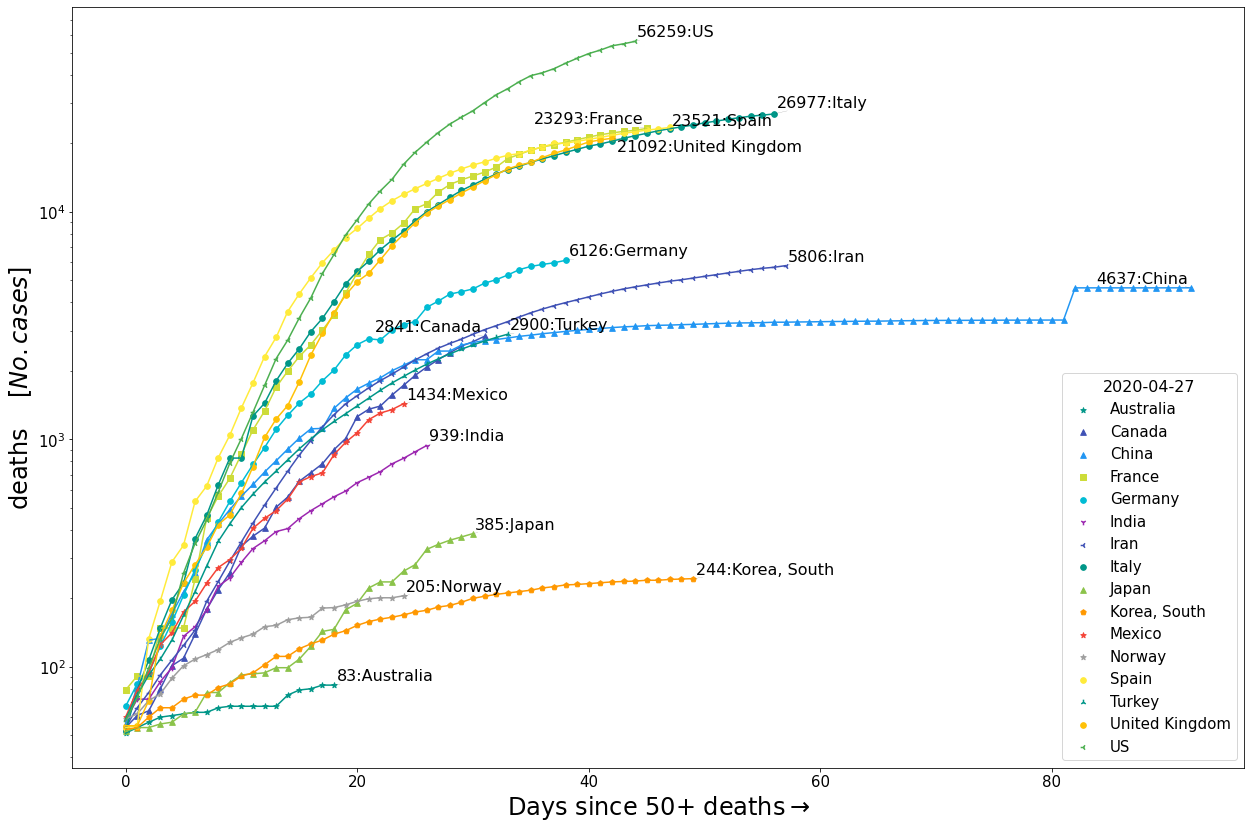

In [9]:
# Location, date, confirmed, deaths, recovered, active, new_confirmed, new_deaths, new_recovered, new_active, rate_of_growth, index

x_str       = 'index_deaths'
y_str       = ["deaths"];
# countries   = ['Italy', 'Spain', 'China', 'India', 'Iran', 'Japan', 'Korea, South', 'Mexico', 'Norway', 'US'];
countries   = ['Australia','Canada','China','China - Hong Kong','France','Germany','India','Iran','Italy','Japan','Korea, South','Mexico','Norway', 'New Zealand', 'Spain','Turkey','United Kingdom','US'];
legPos      = "lower right";
xlogScale   = False
ylogScale   = True;
annotations = True;
adjusttxt   = True;

covid19plot(x_str, y_str, countries, legPos, xlogScale, ylogScale, annotations, adjusttxt)

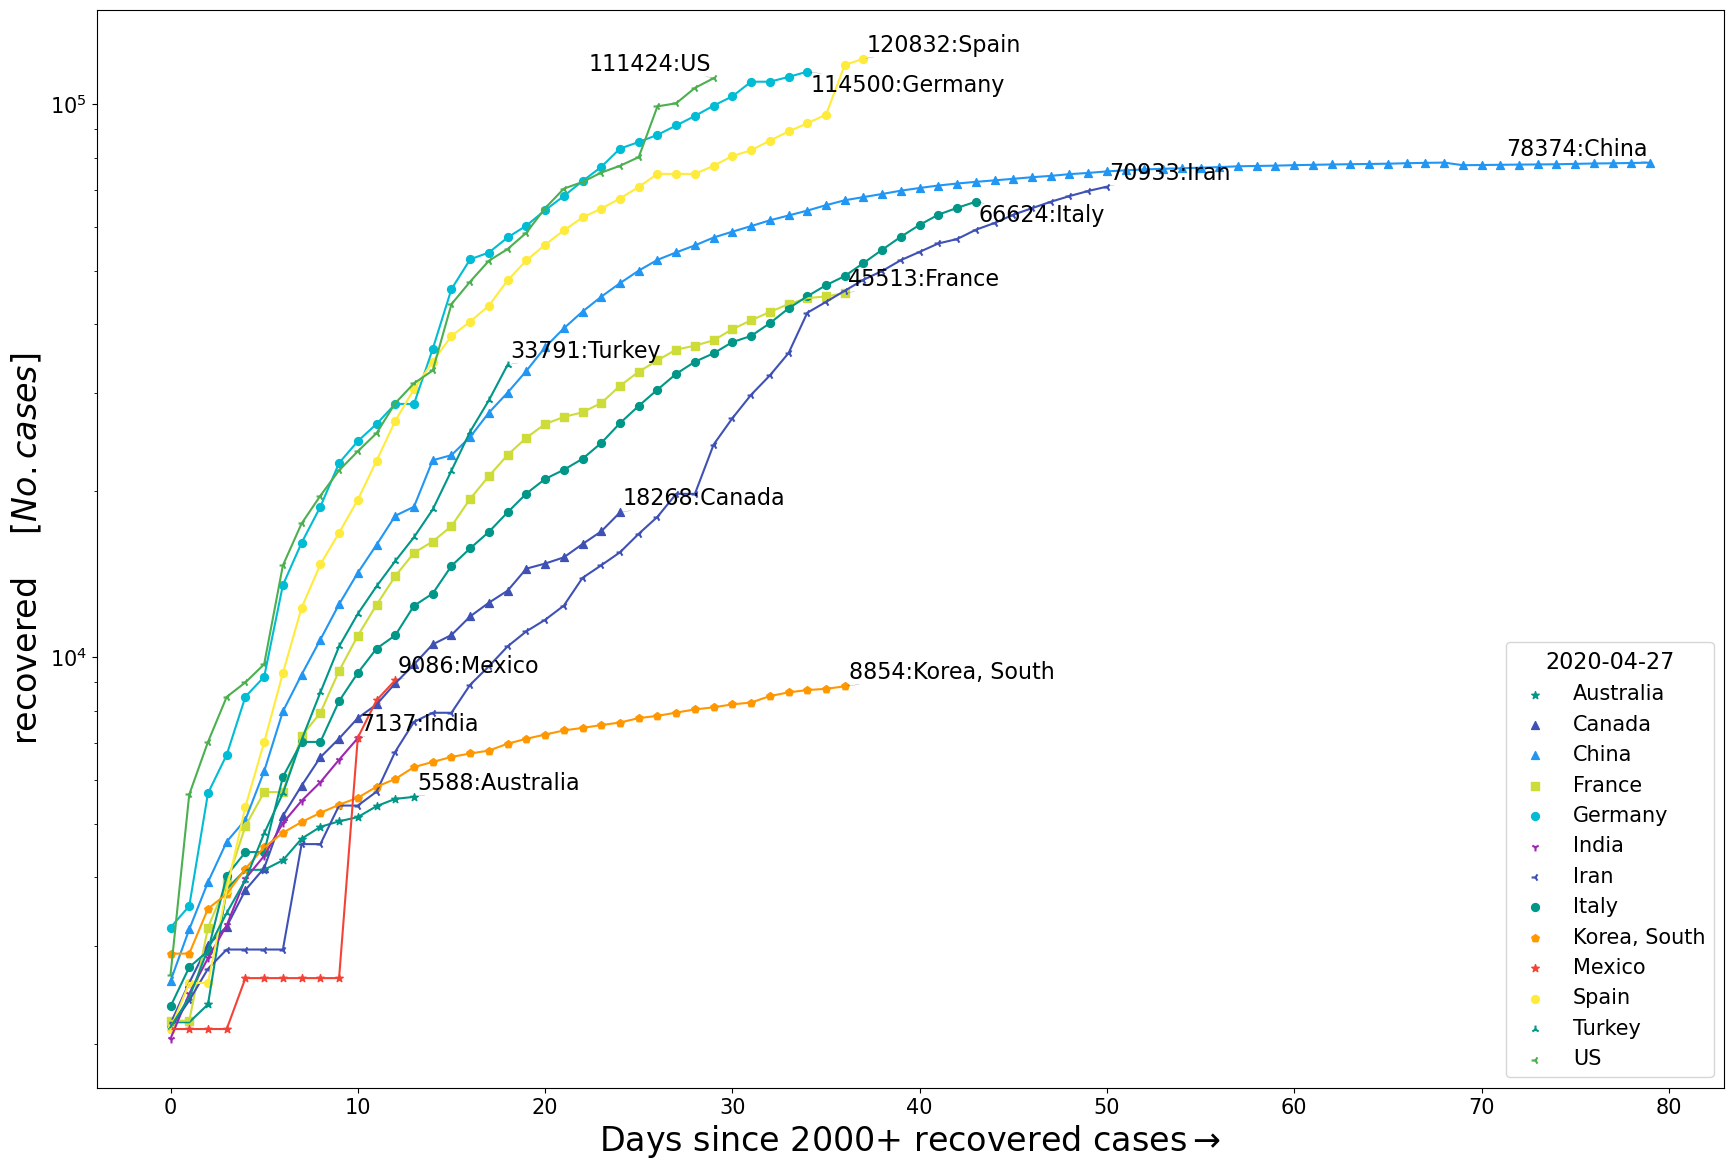

In [10]:
x_str       = 'index_recovered'
y_str       = ["recovered"];
# countries   = ['Italy', 'Spain', 'China', 'India', 'Iran', 'Japan', 'Korea, South', 'Mexico', 'Norway', 'US'];
countries   = ['Australia','Canada','China','China - Hong Kong','France','Germany','India','Iran','Italy','Japan','Korea, South','Mexico','Norway', 'New Zealand', 'Spain','Turkey','United Kingdom','US'];
legPos      = "lower right";
xlogScale   = False
ylogScale   = True;
annotations = True;
adjusttxt   = True;

covid19plot(x_str, y_str, countries, legPos, xlogScale, ylogScale, annotations, adjusttxt)

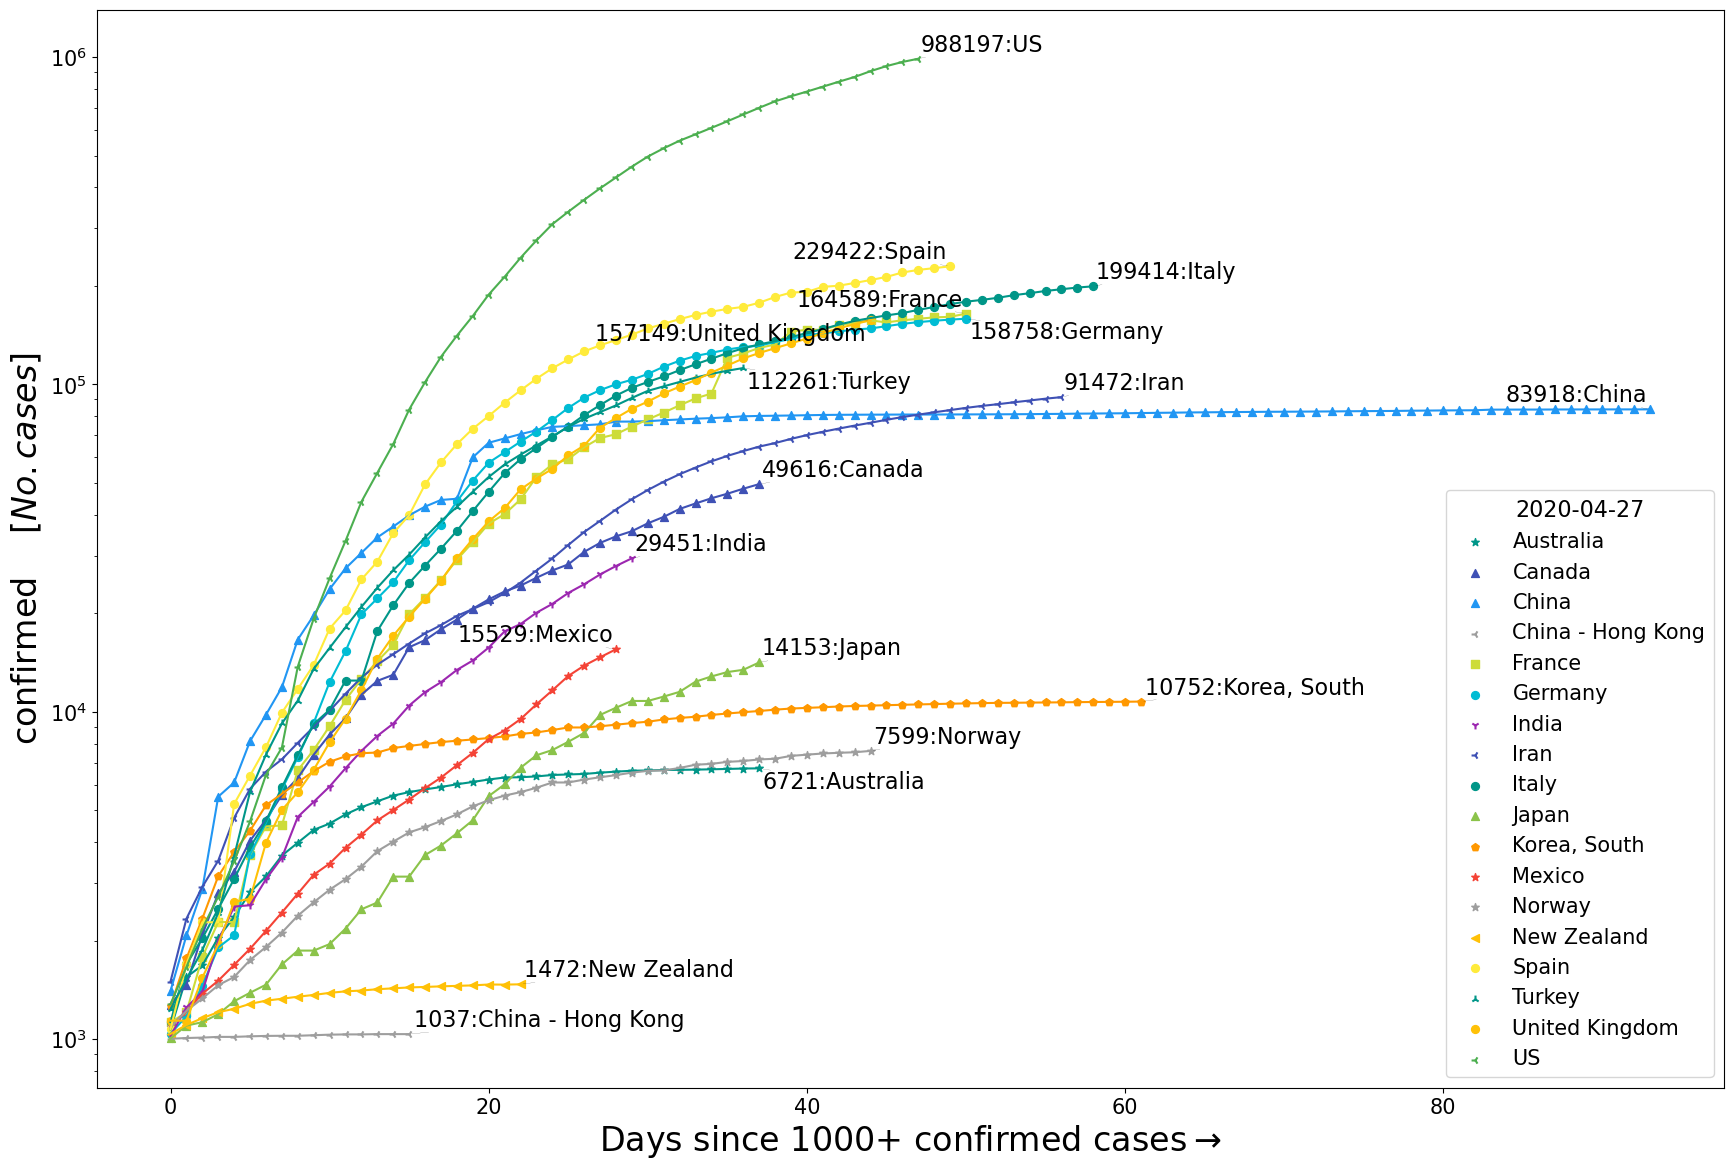

In [11]:
x_str       = 'index_confirmed'
y_str       = ["confirmed"];
# countries   = ['Italy', 'Spain', 'China', 'India', 'Iran', 'Japan', 'Korea, South', 'Mexico', 'Norway', 'US'];
countries   = ['Australia','Canada','China','China - Hong Kong','France','Germany','India','Iran','Italy','Japan','Korea, South','Mexico','Norway', 'New Zealand', 'Spain','Turkey','United Kingdom','US'];
legPos      = "lower right";
xlogScale   = False
ylogScale   = True;
annotations = True;
adjusttxt   = True;

covid19plot(x_str, y_str, countries, legPos, xlogScale, ylogScale, annotations, adjusttxt)

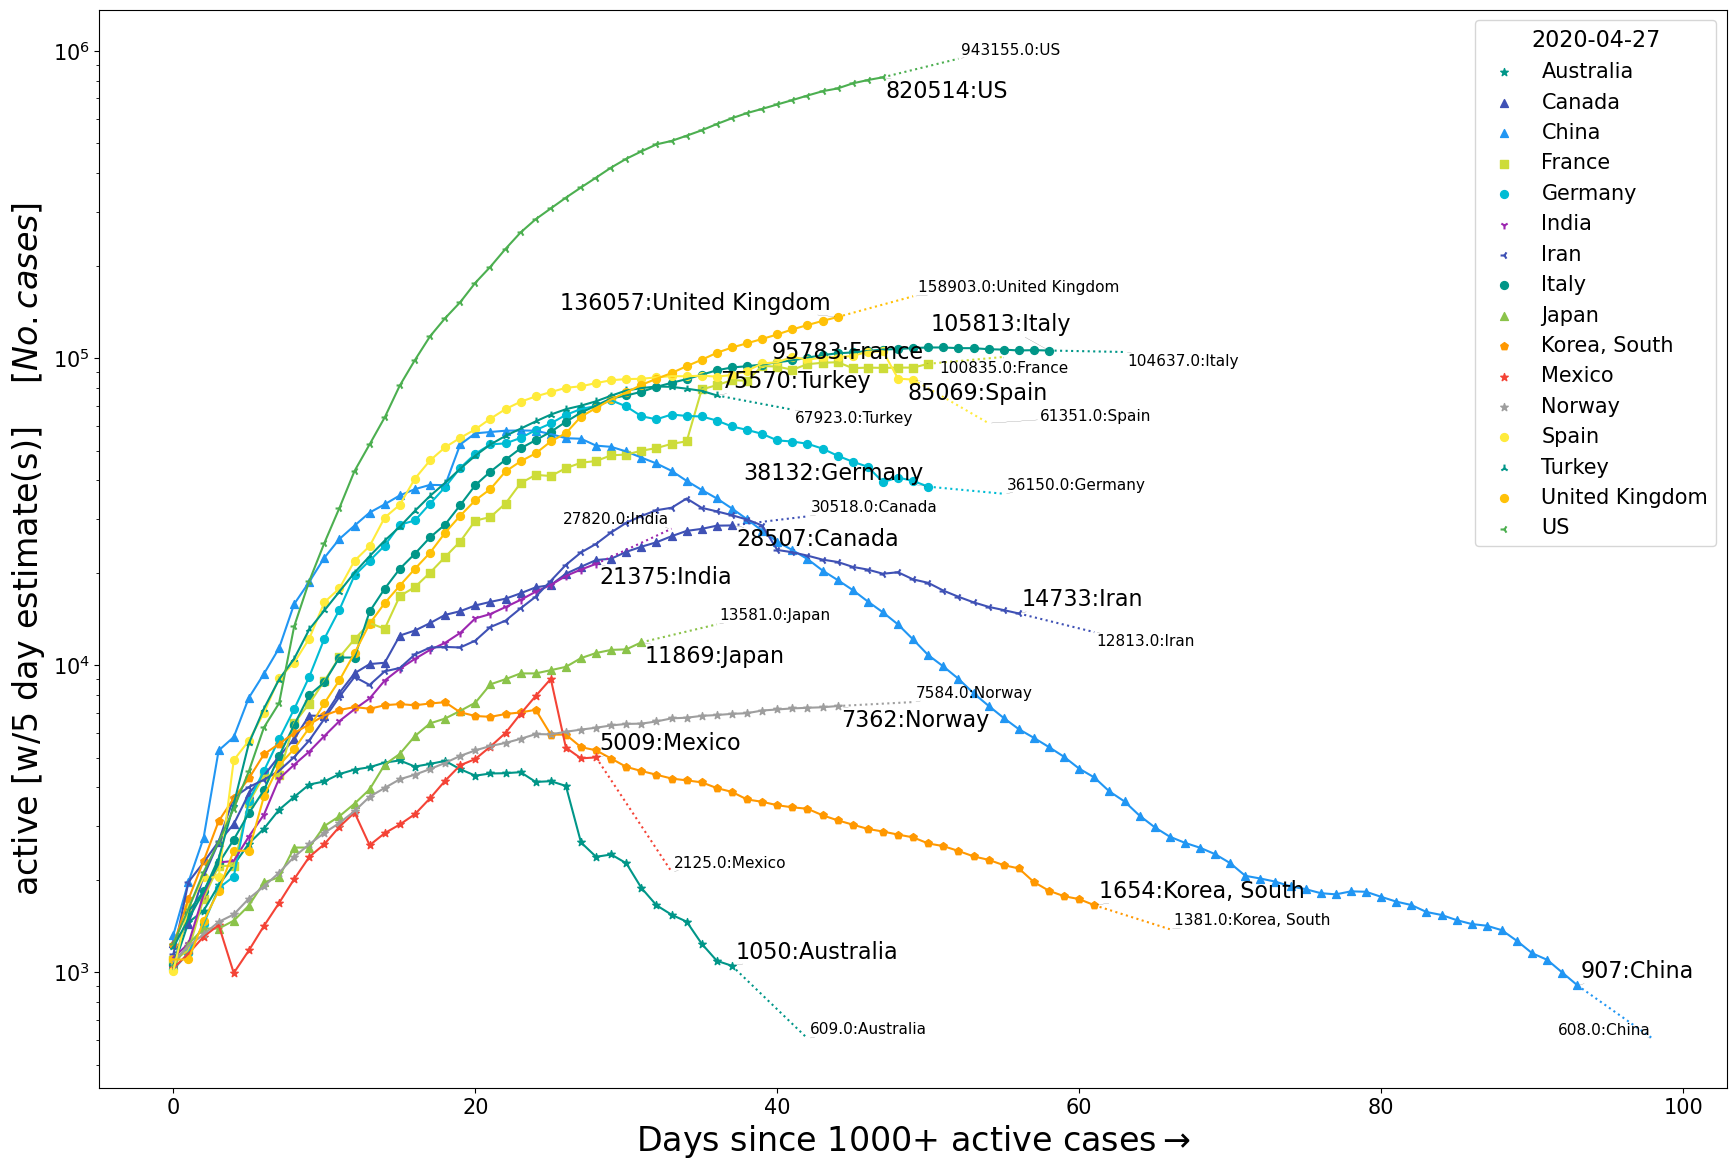

In [12]:
x_str       = 'index_active'
y_str       = ["active"];
# countries   = ['Italy', 'Spain', 'China', 'India', 'Iran', 'Japan', 'Korea, South', 'Mexico', 'Norway', 'US'];
countries   = ['Australia','Canada','China','China - Hong Kong','France','Germany','India','Iran','Italy','Japan','Korea, South','Mexico','Norway', 'New Zealand', 'Spain','Turkey','United Kingdom','US'];
legPos      = "upper right";
xlogScale   = False
ylogScale   = True;
annotations = True;
adjusttxt   = True;

covid19plot(x_str, y_str, countries, legPos, xlogScale, ylogScale, annotations, adjusttxt)

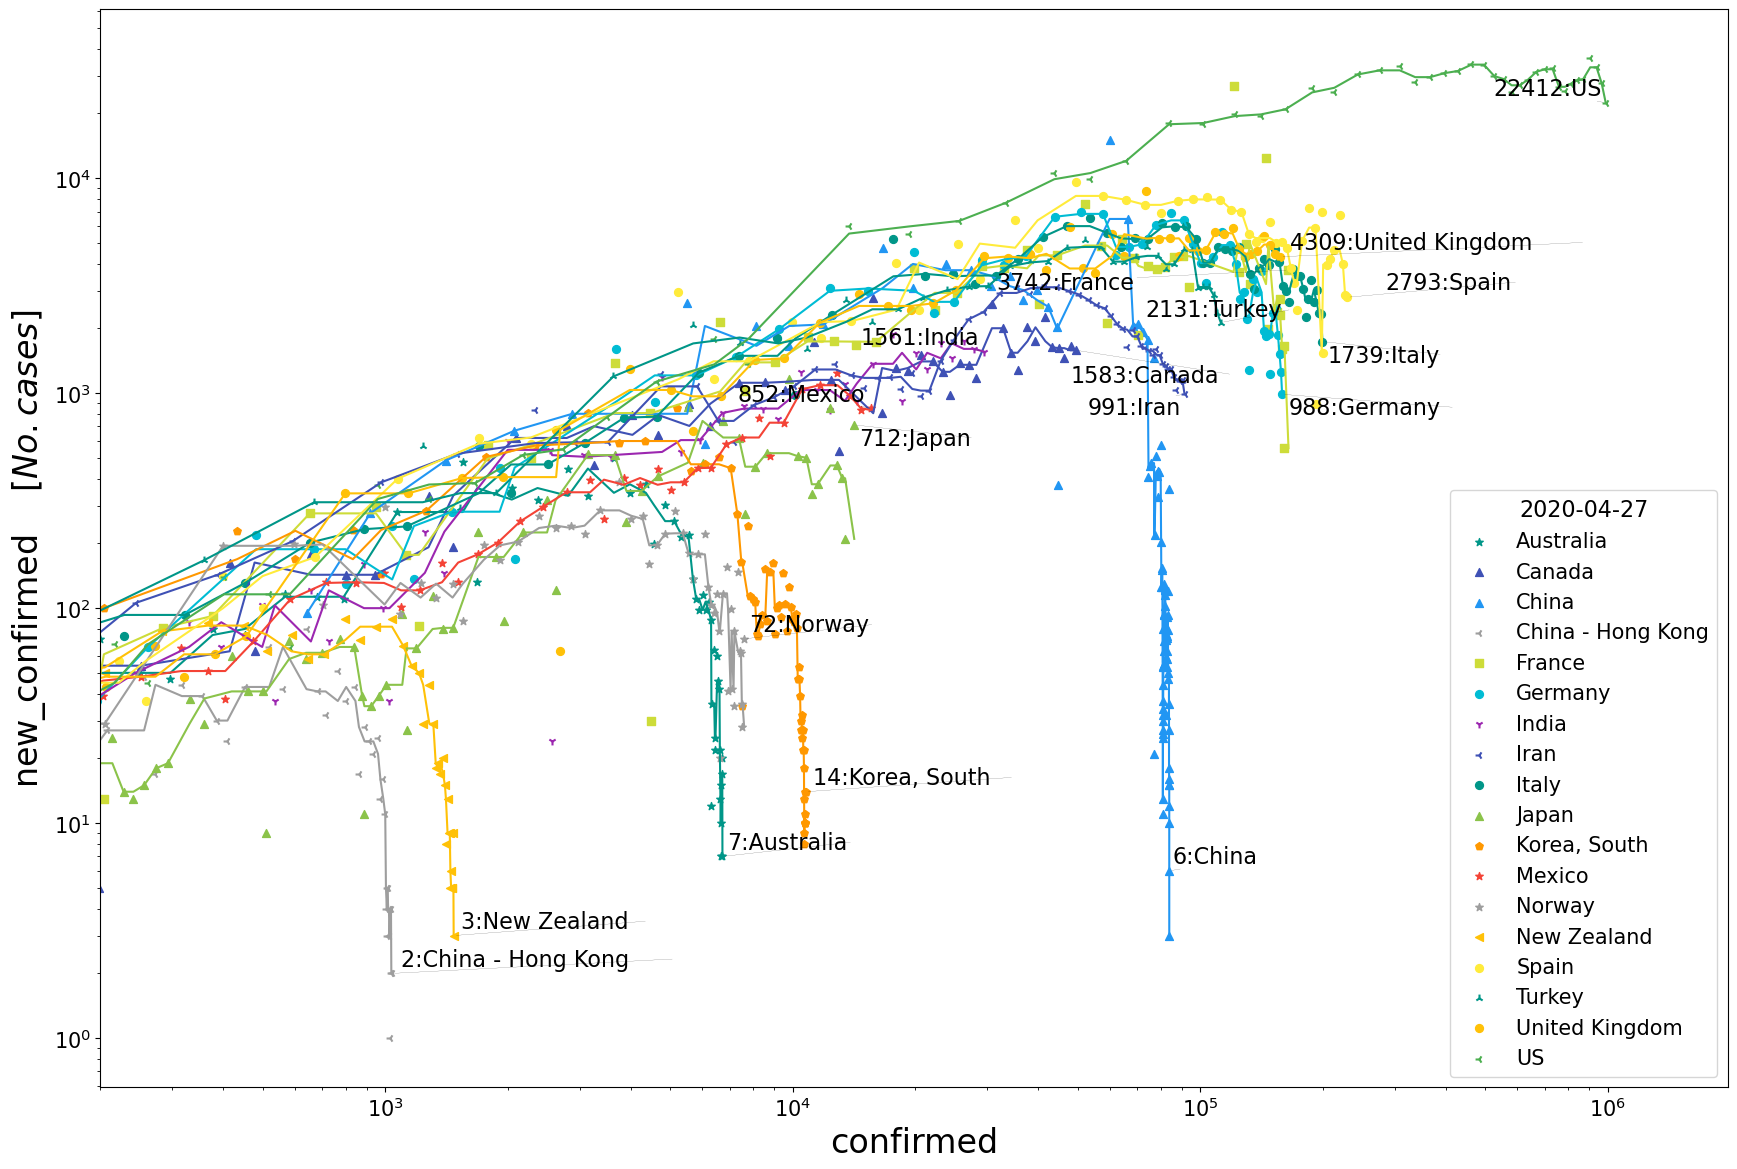

In [13]:
# Chart the new confirmed cases of COVID-19 in the past week vs. the total confirmed cases to date.
# When plotted in this way, exponential growth is represented as a straight line that slopes upwards.

x_str = 'confirmed';
y_str = ['new_confirmed'];

# countries = []
# for c in allcountries:
#     if not(" - " in c):
#         countries.append(c)

countries   = ['Australia','Canada','China','China - Hong Kong','France','Germany','India','Iran','Italy','Japan','Korea, South','Mexico','Norway','New Zealand','Spain','Turkey','United Kingdom','US'];
legPos      = 'lower right';
xlogScale   = True;
ylogScale   = True;
annotations = True;
adjusttxt   = True;

covid19plot(x_str, y_str, countries, legPos, xlogScale, ylogScale, annotations, adjusttxt)

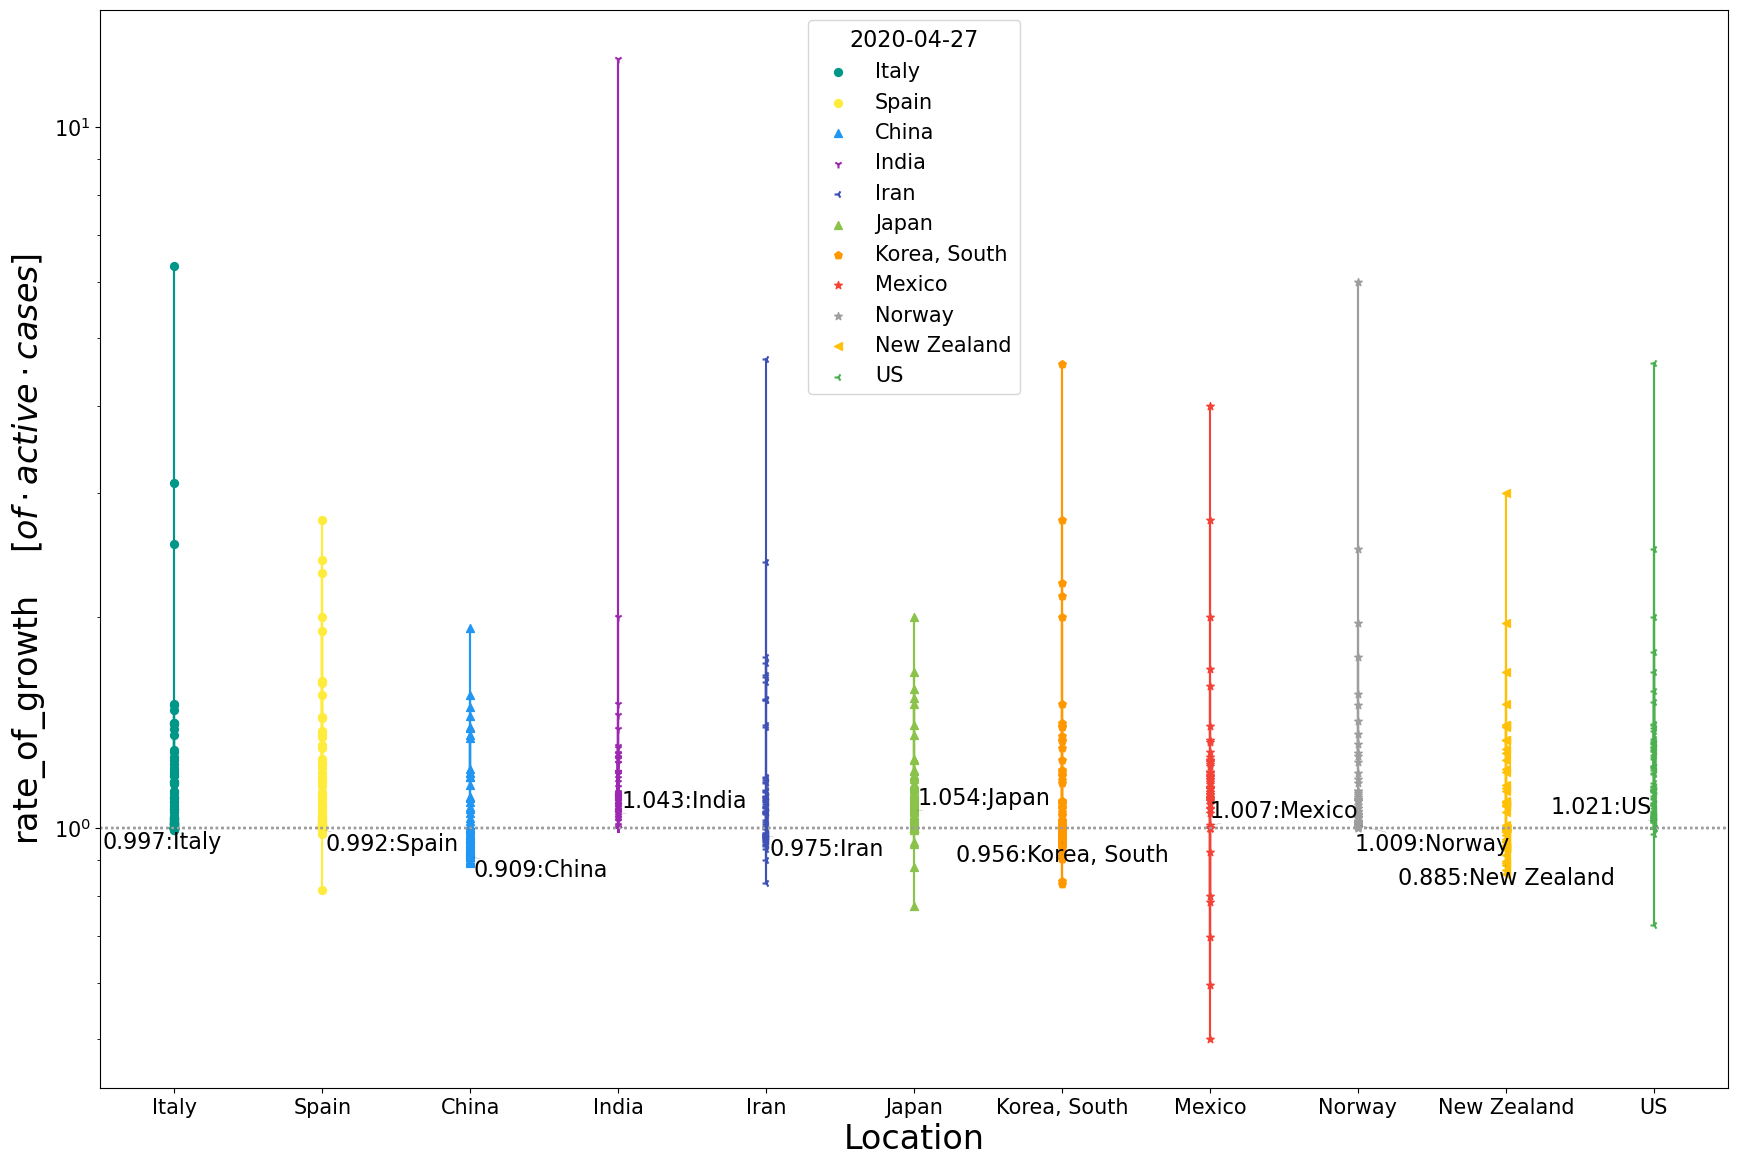

In [14]:
x_str       = 'Location';
y_str       = ["rate_of_growth"];
countries   = ['Italy', 'Spain', 'China', 'India', 'Iran', 'Japan', 'Korea, South', 'Mexico', 'Norway', 'New Zealand', 'US'];
legPos      = "best";
xlogScale   = False;
ylogScale   = True;
annotations = True;
adjusttxt   = True;

covid19plot(x_str, y_str, countries, legPos, xlogScale, ylogScale, annotations, adjusttxt)

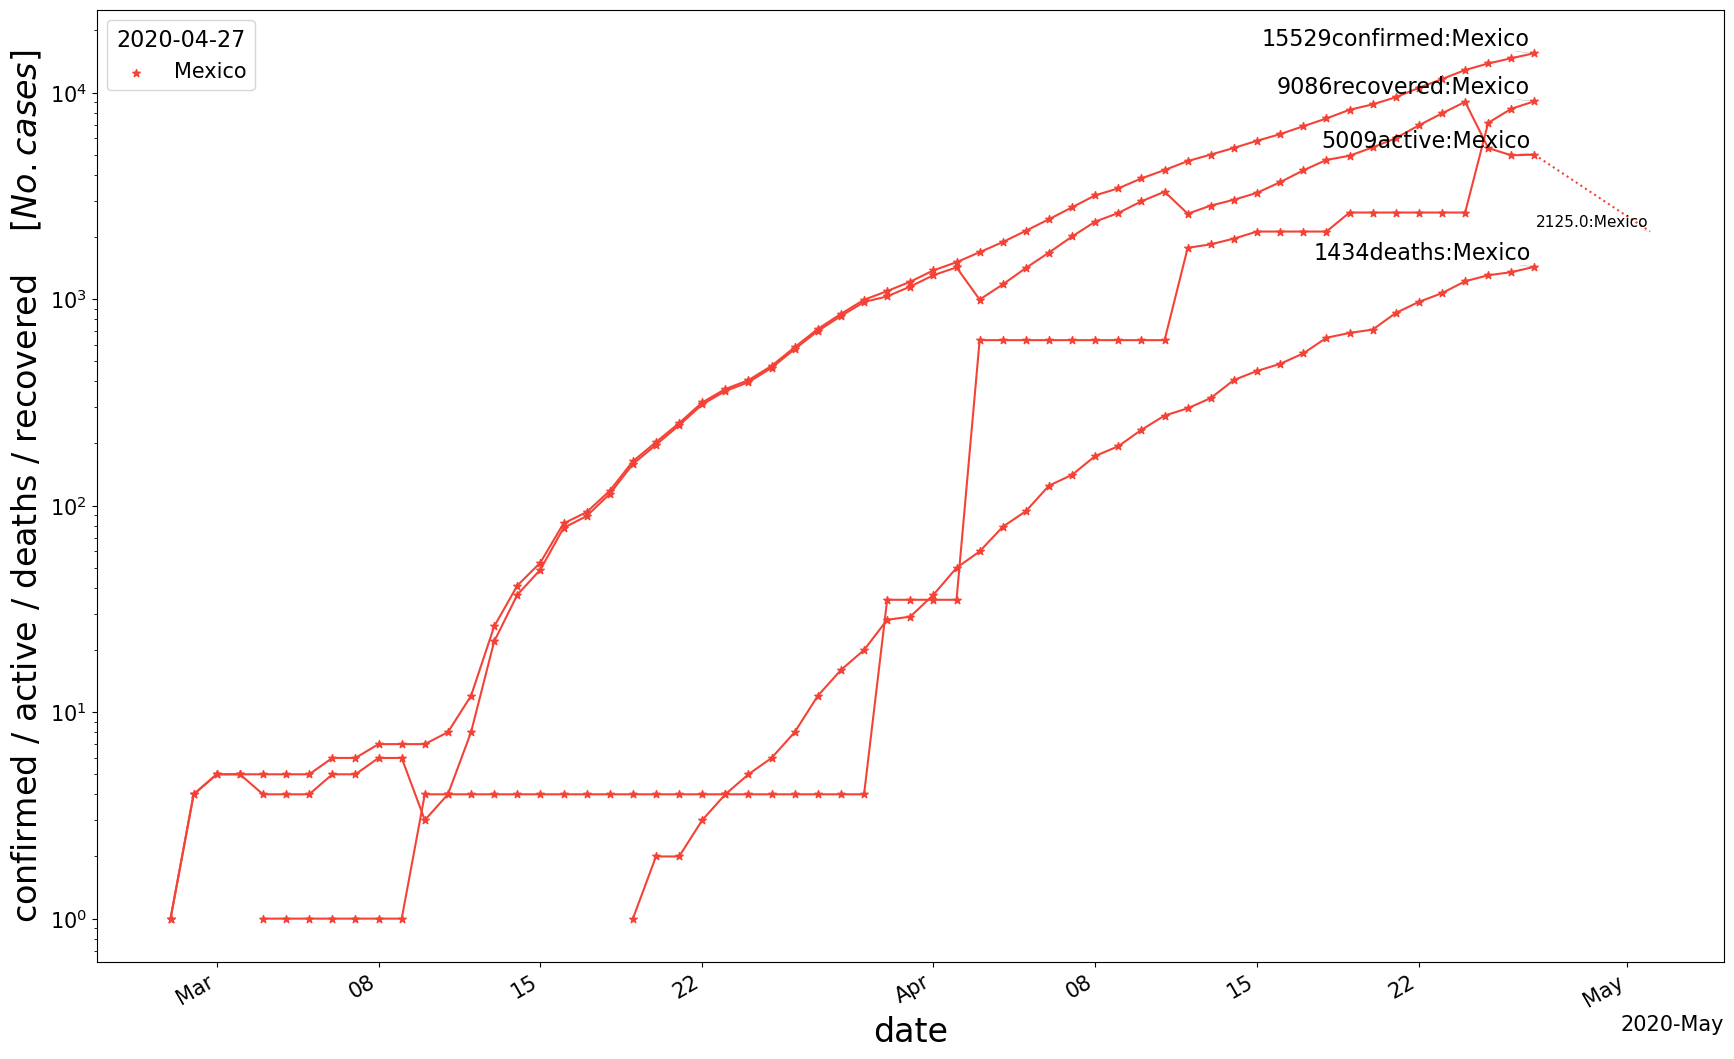

In [15]:
x_str       = 'date'
y_str       = ["confirmed", "active", "deaths", "recovered"];
countries   = ['Mexico'];
legPos      = "upper left";
xlogScale   = False
ylogScale   = True;
annotations = True;
adjusttxt   = True;

covid19plot(x_str, y_str, countries, legPos, xlogScale, ylogScale, annotations, adjusttxt)

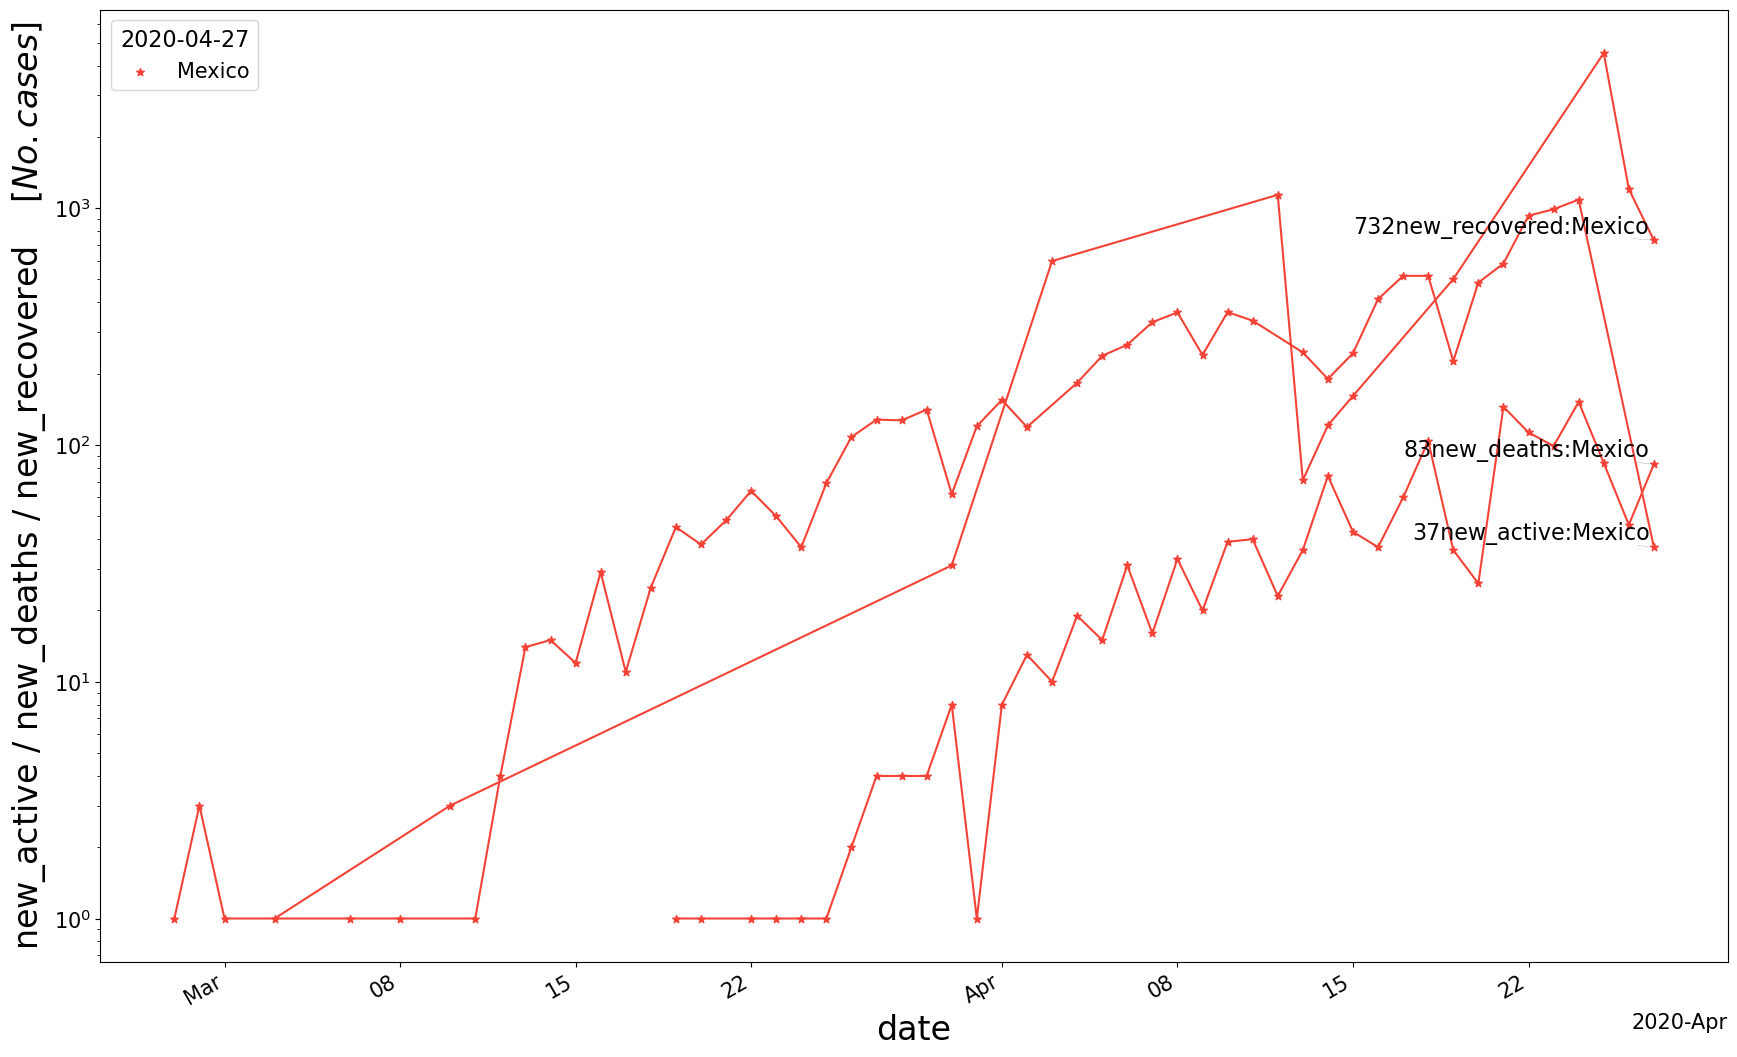

In [16]:
x_str       = 'date';
y_str       = ["new_active", "new_deaths", "new_recovered"];
countries   = ['Mexico'];
legPos      = "upper left";
xlogScale   = False;
ylogScale   = True;
annotations = True;
adjusttxt   = True;

covid19plot(x_str, y_str, countries, legPos, xlogScale, ylogScale, annotations, adjusttxt)

---